# Text-to-Speech

In [ ]:
%%bash
git clone https://github.com/khaykingleb/Text-to-Speech.git

In [ ]:
%cd Text-to-Speech

Download the neccessary packages.

In [ ]:
%%bash
pip install -r requirements.txt

In [4]:
import json

import torchaudio
import torch.nn as nn
import torch

from tts.vocoders import WaveGlow
from tts.models import FastSpeech

from IPython import display

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import warnings
warnings.filterwarnings("ignore")

Download the LJSpeech data.

In [ ]:
%%bash
mkdir ./data
mkdir ./saved
mkdir ./pretrained
wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2 -O ./data/LJSpeech-1.1.tar.bz2
tar -C ./data -xjf ./data/LJSpeech-1.1.tar.bz2
rm ./data/LJSpeech-1.1.tar.bz2

Download the vocoder — WaveGlove.

In [ ]:
%%bash
git clone https://github.com/NVIDIA/waveglow.git
pip install googledrivedownloader

In [6]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
gdd.download_file_from_google_drive(
    file_id="1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF",
    dest_path="./waveglow_256channels_universal_v5.pt"
)

## Training

In [ ]:
%run main.py -c configs/config.json

## Test

In [8]:
def pronounce_text(
    text: str, 
    tokenizer: nn.Module,
    model: nn.Module,
    vocoder: nn.Module,
    device: torch.device,
    sr: int = 22050,
    alpha: float = 1.0,
):  
    model.eval()
    tokens, token_lengths = tokenizer(text)
    durations, melspec = model.inference(tokens.to(device), alpha)
    
    plt.figure(figsize=(14, 6))
    plt.imshow(melspec[0].detach().cpu().numpy())
    plt.xlabel("Time Frame")
    plt.ylabel("Frequency (Hz)")
    plt.title("Melspectrogram")
    plt.grid()

    wav = vocoder.inference(melspec)
    if wav.dim() == 2:
        wav = wav.mean(dim=0)

    plt.figure(figsize=(14, 6))
    plt.plot(wav.detach().cpu().numpy(), alpha=0.7, c="green")
    plt.xlabel("Time", size=16)
    plt.ylabel("Amplitude", size=16)
    plt.show()
    
    display.display(display.Audio(wav.detach().cpu().numpy(), rate=sr))

Download the pretrained model (summer-water-119 in wandb). 

In [ ]:
%%bash
wget https://www.dropbox.com/s/bby35ib9p7aq6o6/best_paper_1.pt?dl=0 \
    -O checkpoint.pt

In [10]:
with open("configs/config.json") as file:
    config = json.load(file)

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tokenizer = torchaudio.pipelines \
    .TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH \
    .get_text_processor()
    
model = FastSpeech(config).to(DEVICE)
vocoder = WaveGlow().eval().to(DEVICE)

checkpoint = torch.load("checkpoint.pt", map_location=DEVICE)
model.load_state_dict(checkpoint["state_dict"])

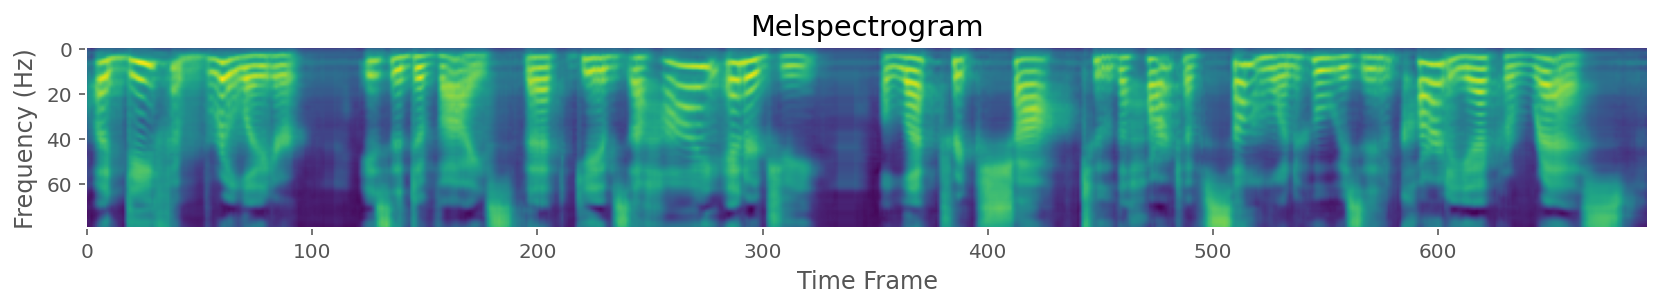

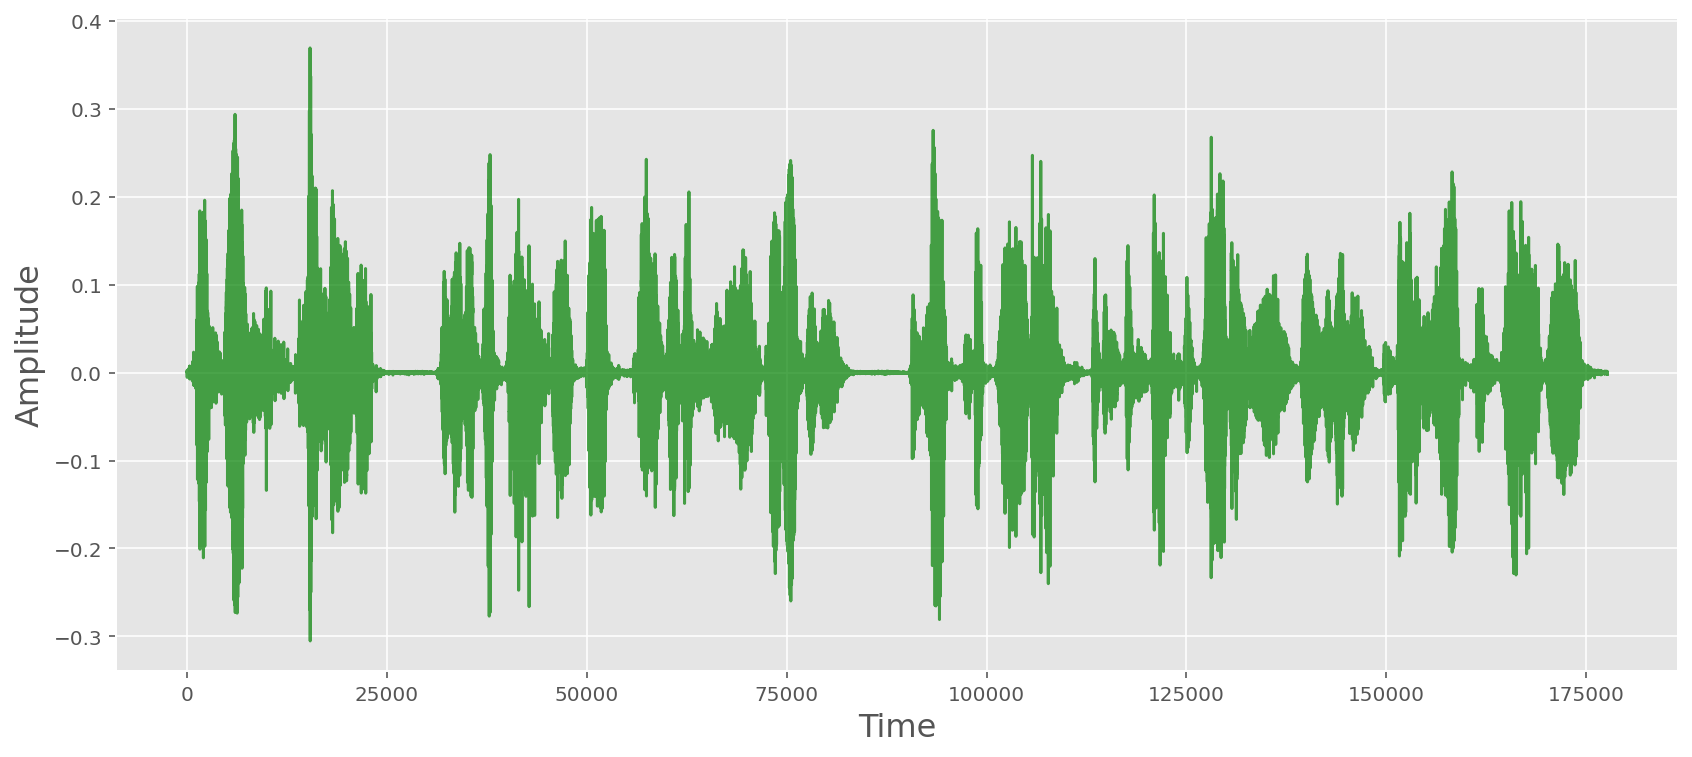

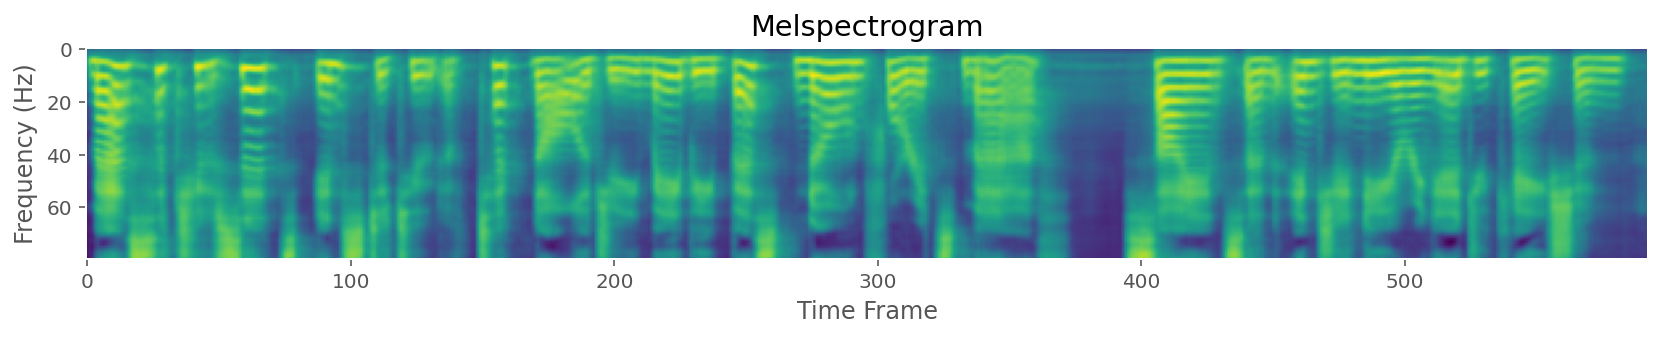

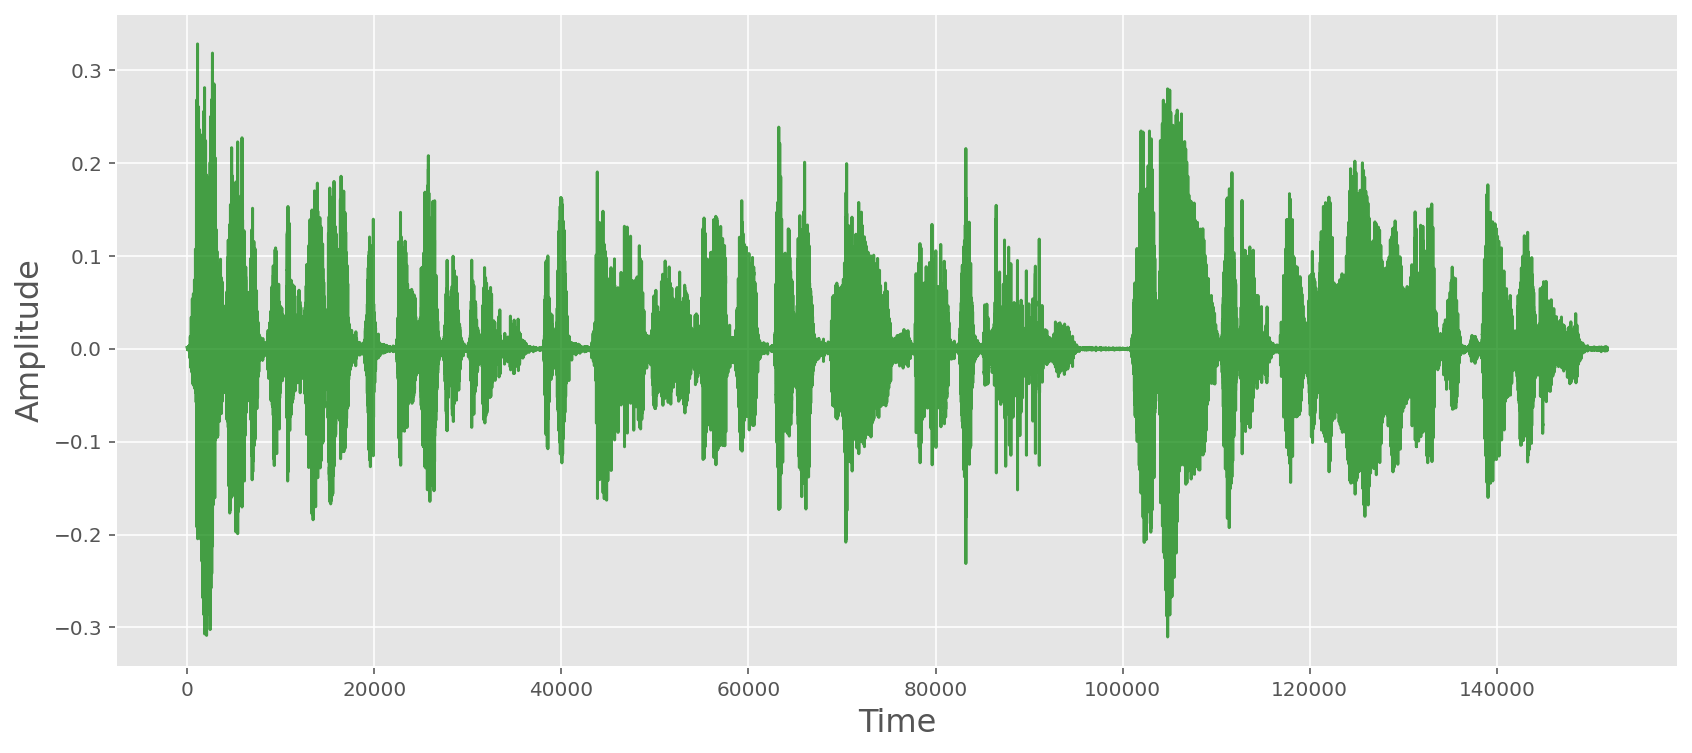

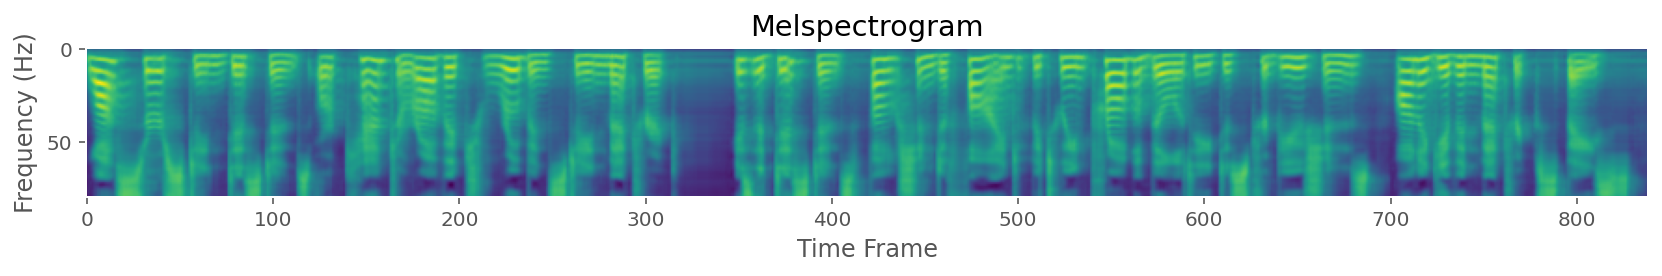

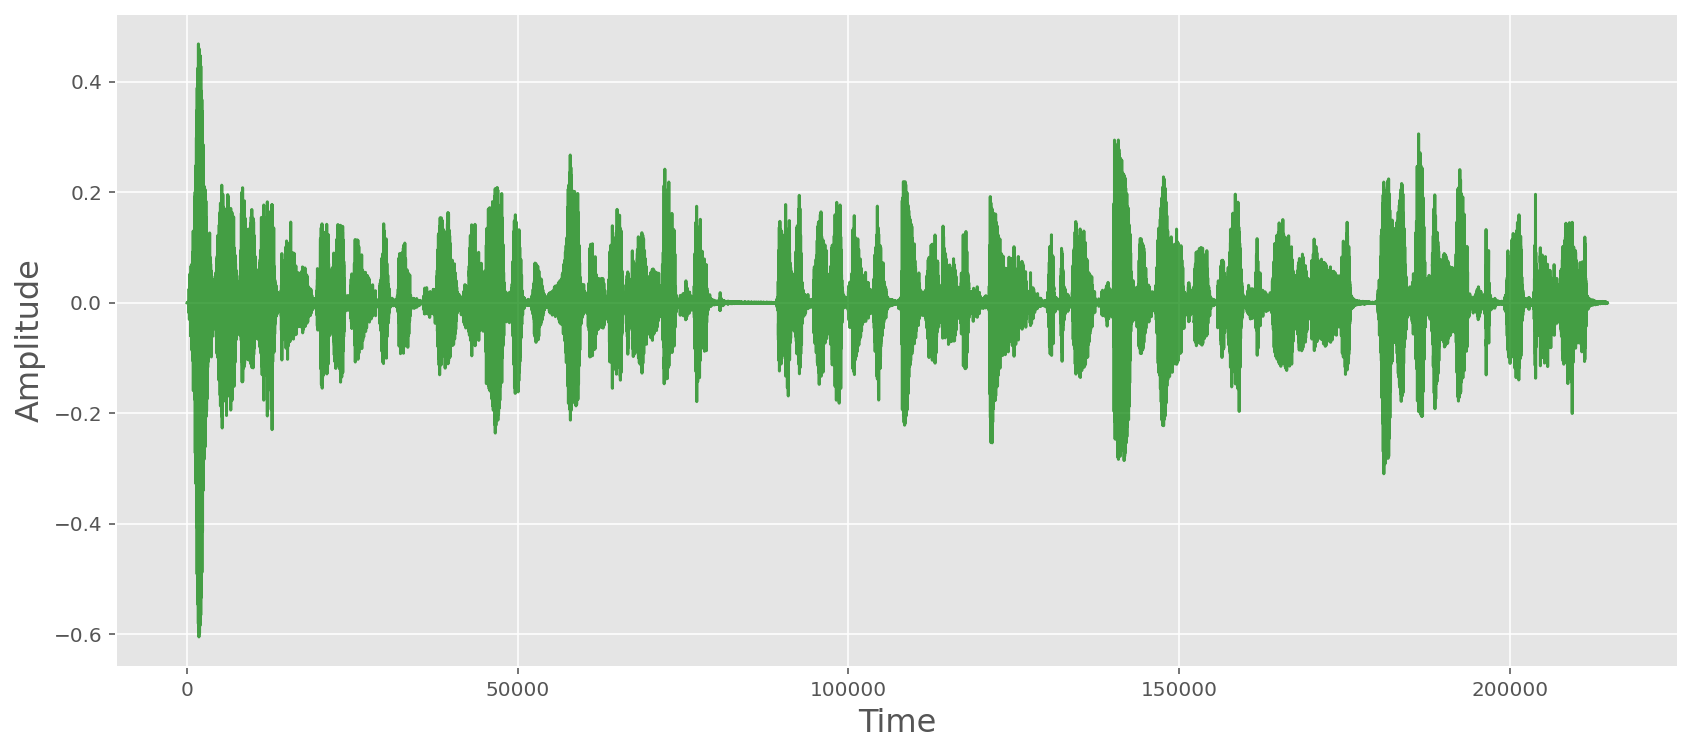

In [12]:
examlpes = [
    "A defibrillator is a device that gives a high energy electric shock " 
    "to the heart of someone who is in cardiac arrest",
    "Massachusetts Institute of Technology may be best known for its "
    "math, science and engineering education",
    "Wasserstein distance or Kantorovich Rubinstein metric is a distance "
    "function defined between probability distributions on a given metric space"
]

for example in examlpes:
    pronounce_text(example, tokenizer, model, vocoder, DEVICE)

## Report

[Link](https://wandb.ai/khaykingleb/tts_one_batch/reports/FastSpeech--VmlldzoxMzA3MDY5)